# <p><center style="font-family:newtimeroman;font-size:180%;"> Abdominal Trauma Detection</center></p>
### Table of contents:

* [Import Libraries and Set Backend](#1)
* [Read Dataset](#2)
* [Split Dataset](#3)
* [Data Preprocessing](#4)
* [Visualization Of Dataset](#5)
* [Build Model](#6)
* [Train Model](#7)
* [Visualization Of Training Results](#8)
* [Save Model](#9)
* [Load Model for Interface](#10)
* [Perform Inference](#11)
* [Output Interpretation](#12)

<a id='1'></a>
# Import Libraries and Set Backend

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!

import tensorflow as tf
import cv2
import keras_cv
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

2024-04-07 14:40:06.734315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 14:40:06.734442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 14:40:06.904871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Note on some observations
Reference Notebook: https://www.kaggle.com/code/aritrag/eda-train-csv

> 1. Class Dependencies: Refers to inherent relationships between classes in the analysis.
> 2. Complementarity: bowel_injury and bowel_healthy, as well as extravasation_injury and extravasation_healthy, are perfectly complementary, with their sum always equal to 1.0.
> 3. Simplification: For the model, only {bowel/extravasation}_injury will be included, and the corresponding healthy status can be calculated using a sigmoid function.
> 4. Softmax: {kidney/liver/spleen}_{healthy/low/high} classifications are softmaxed, ensuring their combined probabilities sum up to 1.0 for each organ, simplifying the model while preserving essential information.

In [2]:
class Config:
    AUTOTUNE = tf.data.AUTOTUNE
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]

config = Config()

# Reproducibility
We would want this notebook to have reproducible results. Here we set the seed for all the random algorithms so that we can reproduce the experiments each time exactly the same way.

In [3]:
keras.utils.set_random_seed(seed=config.SEED)

<a id='2'></a>
# Dataset 
> The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

# Meta Data
> train.csv Target labels for the train set. Note that patients labeled healthy may still have other medical issues, such as cancer or broken bones, that don't happen to be covered by the competition labels.

> 1. patient_id - A unique ID code for each patient.
> 2. [bowel/extravasation]_[healthy/injury] - The two injury types with binary targets.
> 3. [kidney/liver/spleen]_[healthy/low/high] - The three injury types with three target levels.
> 4. any_injury - Whether the patient had any injury at all.


> image_level_labels.csv Train only. Identifies specific images that contain either bowel or extravasation injuries.

> 1. patient_id - A unique ID code for each patient.
> 2. series_id - A unique ID code for each scan.
> 3. instance_number - The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
> 4. injury_name - The type of injury visible in the frame.

In [4]:
BASE_PATH = '/kaggle/input/rsna-atd-512x512-png-v2-dataset'

In [5]:
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


<a id='3'></a>
# Split Dataset

We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [6]:
# split data for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [7]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

<a id='4'></a>
# Data Preprocessing
Here we build the data pipeline using tf.data. Using tf.data we can map out data to an augmentation pipeline simple by using the map API.

Adding augmentations to the data pipeline is as simple as adding a layer into the list of layers that the Augmenter processes.

Reference: https://keras.io/api/keras_cv/layers/augmentation/

In [8]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            
        ]
    )
    
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    
    return ds

In [9]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

<a id='5'></a>
# Visualization of Sample Images

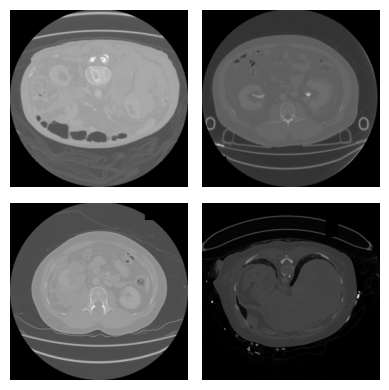

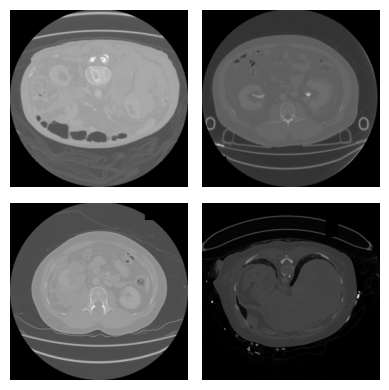

In [10]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

<a id='6'></a>
# Build Model

> Build Model¶
> We are going to load a pretrained model from the list of avaiable backbones in KerasCV. We are using the ResNetBackbone as our backbone. The practise of using a pretrained model and finetuning it to a specific dataset is prevalent in the DL community.
> 
> We use the Functional API of Keras to build the model. The design of the model would be such that we input a single image and we get different heads for the various predictions we need (kidney, spleen...).
> 
> We have also added a Learning Rate scheduler for you to work with. When an athlete trains, the first step is always to warm up. We take a similar approach to training our models. We warm up with model where the learning rate increses from the initial LR to a higher LR. After the warmup stage we provide a decay algorithm (cosine here).

In [11]:
def build_model(warmup_steps, decay_steps):
    # define input     
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
    # define Backbone
    backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
    backbone.include_rescaling = False
    x = backbone(inputs)
    
    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # create model
    print("[INFO] Building the model...")
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # cosine decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
    
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    
    print("[INFO] Compiling the model...")
    
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )
    
    
    return model

<a id='7'></a>
# Train Model

In [12]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=96640
warmup_steps=9664
decay_steps=86976


In [13]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# generate train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

Attaching 'config.json' from model 'keras/resnetv1/keras/resnet50_imagenet/2' to your Kaggle notebook...


[INFO] Building the model...


Attaching 'config.json' from model 'keras/resnetv1/keras/resnet50_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/resnetv1/keras/resnet50_imagenet/2' to your Kaggle notebook...


[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/10


I0000 00:00:1712500935.870247      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712500935.953968      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - bowel_accuracy: 0.9063 - extra_accuracy: 0.8324 - kidney_accuracy: 0.7564 - liver_accuracy: 0.7539 - loss: 2.5525 - spleen_accuracy: 0.7284

W0000 00:00:1712501065.823347      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712501074.538913      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - bowel_accuracy: 0.9062 - extra_accuracy: 0.8319 - kidney_accuracy: 0.7568 - liver_accuracy: 0.7547 - loss: 2.5507 - spleen_accuracy: 0.7284 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 9.4050 - val_spleen_accuracy: 0.6773
Epoch 2/10


W0000 00:00:1712501103.685254      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/151 ━━━━━━━━━━━━━━━━━━━━ 116s 752ms/step - bowel_accuracy: 0.5710 - extra_accuracy: 0.8492 - kidney_accuracy: 0.7911 - liver_accuracy: 0.7045 - loss: 4.9571 - spleen_accuracy: 0.6456 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6967 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 3.7440 - val_spleen_accuracy: 0.6773
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 116s 753ms/step - bowel_accuracy: 0.4930 - extra_accuracy: 0.8676 - kidney_accuracy: 0.7980 - liver_accuracy: 0.7140 - loss: 3.7750 - spleen_accuracy: 0.7021 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.5660 - val_kidney_accuracy: 0.8113 - val_liver_accuracy: 0.8697 - val_loss: 4.4111 - val_spleen_accuracy: 0.6773
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 116s 751ms/step - bowel_accuracy: 0.6527 - extra_accuracy: 0.8906 - kidney_accuracy: 0.8073 - liver_accuracy: 0.7287 - loss: 3.3823 - spleen_accuracy: 0.7527 - val_bowel_accuracy: 0.5205 - val_extra_accuracy: 0.6703 - val_kidney_accuracy: 0.81

<a id='8'></a>
# Visualization of Results

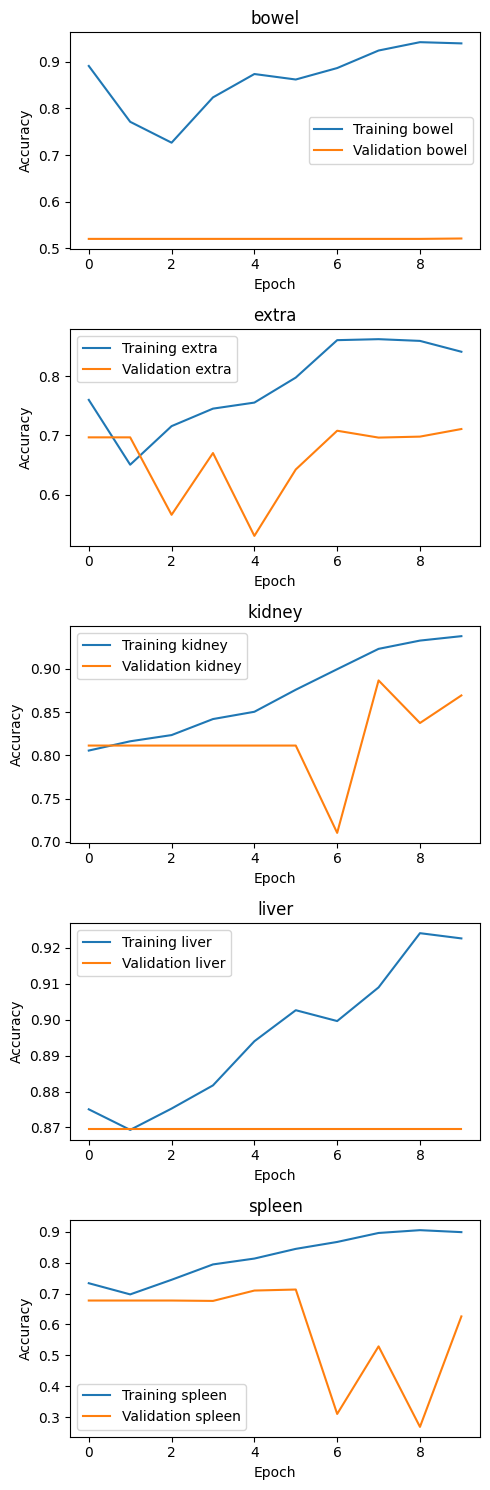

In [14]:
# create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# flatten axes to iterate through them
axes = axes.flatten()

# iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

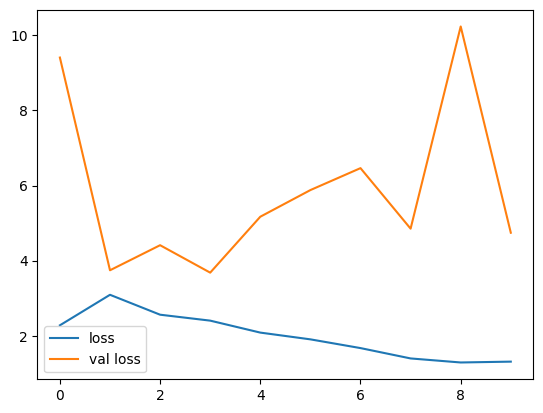

In [15]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [16]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 3.681
>>>> BEST Acc   : 0.710
>>>> BEST Epoch : 3

ORGAN Acc:
  >>>> Bowel           : 0.520
  >>>> Extravasation   : 0.670
  >>>> Liver           : 0.870
  >>>> Kidney          : 0.811
  >>>> Spleen          : 0.676


<a id='9'></a>
# Save the Model

In [17]:
# save the model
model.save("rsna-atd-model.keras")

<a id='10'></a>
# Load Model for Interface

In [18]:
MODEL_PATH = '/kaggle/working/rsna-atd-model.keras'

In [19]:
atd_model = keras.models.load_model(MODEL_PATH)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (64, 256, 256, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net50_backbone  │ (64, 8, 8, 2048)  │ 23,561,152 │ input_layer[0][0] │
│ (ResNetBackbone)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (64, 2048)        │          0 │ res_net50_backbo… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (64, 32)          │     65,568 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (64, 32)          │     65,568 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (64, 32)          │     65,568 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (64, 32)          │     65,568 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (64, 32)          │     65,568 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bowel (Dense)       │ (64, 1)           │         33 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra (Dense)       │ (64, 1)           │         33 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ liver (Dense)       │ (64, 3)           │         99 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kidney (Dense)      │ (64, 3)           │         99 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spleen (Dense)      │ (64, 3)           │         99 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,561,826 (272.99 MB)

 Trainable params: 23,836,235 (90.93 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,672,471 (181.86 MB)

<a id='11'><a/>
# Perform Interface

In [20]:
# read the image
dtest = cv2.imread('/kaggle/input/rsna-atd-512x512-png-v2-dataset/test_images/48843/62825/30.png') 

# resize image to match model's expected sizing
dtest = cv2.resize(dtest, (256,256))     

# reshape image to add batch dimension and match model's expected input
dtest = dtest.reshape(-1, 256, 256, 3)

organs = ['Bowel','Extravasation','Liver','Kidney','Spleen']

# predict the result
pred = atd_model.predict(dtest)
pred = np.concatenate(pred, axis=-1).astype("float32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


<a id='12'></a>
# Output Interpretation

In [21]:
# interpretation of the prediction
interpretation = {organ: ('Present' if pred[0][i] > 0.5 else 'Not Present') for i, organ in enumerate(organs)}
print(interpretation)

{'Bowel': 'Present', 'Extravasation': 'Present', 'Liver': 'Present', 'Kidney': 'Not Present', 'Spleen': 'Not Present'}
